# Problem 2: Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Mini Facade dataset.

## Setup
First, we will install some required packages for this notebook and download the Mini Facade dataset. 


In [ ]:
# install required packages and download the dataset
!pip install colormap easydev pypng
!gdown --fuzzy https://drive.google.com/file/d/1y9lO-_EDo_0MeUx5VJAUoS9nIoG45QSr/view?usp=share_link
!unzip facades.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.3 MB/s eta 0:00:00
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15630 sha256=eab4a8ca1c1beceb2daf3b9e35bf87a4ab7872fae164a39048cbc76152a759f4
  Stored in directory: /root/.cache/pip/wheels/bb/25/18/6b007d77ac1220e0530efa2af14569bb803d77f140366fb313
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64214 sha256=3bf37ee1af286bbce8d5417f83429601913ab92463c65b187c09cf143cc2b971
  Stored in directory: /root/.cache/pip/wheels/c5/a3/df/e8e19f6f1674c2b0574ccc1a156292b599709eaa4feeea0fcf
Successfully built colormap easydev
Downloading...
From: https://drive.google.com/uc?id=1y9lO-_EDo_0MeUx5VJAUoS9nIoG45QSr
To: /content/fac

In [ ]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

## Dataset
We will create a custom Dataset function for the Mini Facade dataset. You don't have to change anything here.

In [ ]:
class FacadeDataset(Dataset):
  def __init__(self, flag, dataDir='./facades/', data_range=(0, 8), n_class=5, 
               onehot=False):
    self.onehot = onehot
    assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
    print("load "+ flag+" dataset start")
    print("    from: %s" % dataDir)
    print("    range: [%d, %d)" % (data_range[0], data_range[1]))
    self.dataset = []
    for i in range(data_range[0], data_range[1]):
      img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

      pngreader = png.Reader(filename=os.path.join(dataDir,flag,
                                                   'eecs442_%04d.png' % i))
      w,h,row,info = pngreader.read()
      label = np.array(list(row)).astype('uint8')

      # Normalize input image
      img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
      # Convert to n_class-dimensional onehot matrix
      label_ = np.asarray(label)
      label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
      for j in range(n_class):
          label[j, :] = label_ == j
      self.dataset.append((img, label))
    print("load dataset done")

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    img, label = self.dataset[index]
    label = torch.FloatTensor(label)
    if not self.onehot:
      label = torch.argmax(label, dim=0)
    else:
      label = label.long()

    return torch.FloatTensor(img), torch.LongTensor(label)

Now, we will create a dataloader for the Mini Facade dataset. You have to play with the size of train-val split and adjust the batch sizes for the splits.

In [ ]:
N_CLASS=5
##############################################################################
# TODO: Change data_range so that train_data and val_data splits the 906     #
# samples under "train" folder. You can decide how to split.                 #
#                                                                            # 
# TODO: Adjust batch_size for loaders                                        #
##############################################################################
train_data = FacadeDataset(flag='train', data_range=(0,800), onehot=False)
train_loader = DataLoader(train_data, batch_size=4)
val_data = FacadeDataset(flag='train', data_range=(800,906), onehot=False)
val_loader = DataLoader(val_data, batch_size=4)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

load train dataset start
    from: ./facades/
    range: [0, 800)
load dataset done
load train dataset start
    from: ./facades/
    range: [800, 906)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done


## Model
Design and implement your Convolutional NeuralNetworks to perform semantic segmentation on the Mini Facade dataset. 

You can build a simple neural network based on the U-net [1]:
1. Conv-ReLU-Conv-ReLU that goes from `3 -> 64 -> 64` ( H x W )
2. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/2 x W/2 )
3. Conv-ReLU-Conv-ReLU that goes from `64 -> 128 -> 128` ( H/2 x W/2 )
4. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/4 x W/4 )
5. Conv that goes from `128 -> 128` ( H/4 x W/4 )
6. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H/2 x W/2 )
6. Conv-ReLU-Conv-ReLU that goes from `128 -> 64 -> 64` ( H/2 x W/2 )
7. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H x W )
8. Conv-ReLU-Conv-ReLU that goes from `64 -> 64 -> 5` ( H x W )

Be careful while choosing the kernel size, padding and stride in the convolution layer. You can compute the output shape after a convolution by using the formula:

$$
X_{out} = (X_{in} - K + 2P)/S +1
$$

Where, $X_{out}$ & $X_{in}$ are the output and input shape of the feature map and $K$, $P$ & $S$ are the kernel size, padding and stride repectively.

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-net:  Convolutional networks for biomedical image seg-mentation,”ArXiv, vol. abs/1505.04597, 2015

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.n_class = N_CLASS
    ########################################################################
    # TODO: Implement a sematic segmentation model                         #
    ########################################################################

    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    self.encoder1 = conv_block(3, 64)
    self.pool1 = nn.MaxPool2d(2)
    self.encoder2 = conv_block(64, 128)
    self.pool2 = nn.MaxPool2d(2)
    self.middle = conv_block(128, 128)
    self.decoder2 = conv_block(256, 64)
    self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.decoder1 = conv_block(128, 64)
    self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.final_conv = nn.Conv2d(64, self.n_class, kernel_size=1)
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

  def forward(self, x):
    ########################################################################
    # TODO: Implement the forward pass                                     #
    ########################################################################
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(self.pool1(enc1))
    middle = self.middle(self.pool2(enc2))

    dec2 = self.decoder2(torch.cat([self.up2(middle), enc2], dim=1))
    dec1 = self.decoder1(torch.cat([self.up1(dec2), enc1], dim=1))
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return self.final_conv(dec1)

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [ ]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,224,224))

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         147,584
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]         147,584
             ReLU-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [ ]:
def save_label(label, path):
  '''
  Function for ploting labels.
  '''
  colormap = [
      '#000000',
      '#0080FF',
      '#80FF80',
      '#FF8000',
      '#FF0000',
  ]
  assert(np.max(label)<len(colormap))
  colors = [hex2rgb(color, normalise=False) for color in colormap]
  w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
  with open(path, 'wb') as f:
      w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
  '''
  Function for training.
  '''
  start = time.time()
  running_loss = 0.0
  cnt = 0
  net = net.train()
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    cnt += 1
  end = time.time()
  running_loss /= cnt
  print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
  return running_loss

def test(testloader, net, criterion, device):
  '''
  Function for testing.
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)
      loss = criterion(output, labels)
      losses += loss.item()
      cnt += 1
  print('\n',losses / cnt)
  return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
  '''
  Calculate Average Precision
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    preds = [[] for _ in range(5)]
    heatmaps = [[] for _ in range(5)]
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images).cpu().numpy()
      for c in range(5):
        preds[c].append(output[:, c].reshape(-1))
        heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

    aps = []
    for c in range(5):
      preds[c] = np.concatenate(preds[c])
      heatmaps[c] = np.concatenate(heatmaps[c])
      if heatmaps[c].max() == 0:
        ap = float('nan')
      else:
        ap = ap_score(heatmaps[c], preds[c])
        aps.append(ap)
      print("AP = {}".format(ap))
    print("Average Precision (all classes) = {}".format(np.mean(aps)))
  return None


def get_result(testloader, net, device, folder='output_train'):
  result = []
  cnt = 1
  os.makedirs(folder, exist_ok=True)
  with torch.no_grad():
    net = net.eval()
    cnt = 0
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)[0].cpu().numpy()
      c, h, w = output.shape
      assert(c == N_CLASS)
      y = np.argmax(output, 0).astype('uint8')
      gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
      save_label(y, './{}/y{}.png'.format(folder, cnt))
      save_label(gt, './{}/gt{}.png'.format(folder, cnt))
      plt.imsave('./{}/x{}.png'.format(folder, cnt),
                 ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))
      cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure()
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.45 AP** on the test set


Start training
-----------------Epoch = 1-----------------


100%|██████████| 200/200 [00:32<00:00,  6.21it/s]



 [epoch 1] loss: 1.226 elapsed time 32.227
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 11.44it/s]



 1.1315253730173465
-----------------Epoch = 2-----------------


100%|██████████| 200/200 [00:30<00:00,  6.53it/s]



 [epoch 2] loss: 1.123 elapsed time 30.646
Validation loss: 


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]



 1.0549918346934848
-----------------Epoch = 3-----------------


100%|██████████| 200/200 [00:30<00:00,  6.58it/s]



 [epoch 3] loss: 1.033 elapsed time 30.427
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 12.77it/s]



 0.9424796523871245
-----------------Epoch = 4-----------------


100%|██████████| 200/200 [00:31<00:00,  6.40it/s]



 [epoch 4] loss: 0.957 elapsed time 31.276
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 13.11it/s]



 0.8949777351485358
-----------------Epoch = 5-----------------


100%|██████████| 200/200 [00:30<00:00,  6.57it/s]



 [epoch 5] loss: 0.910 elapsed time 30.439
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 11.21it/s]



 0.852702655174114
-----------------Epoch = 6-----------------


100%|██████████| 200/200 [00:30<00:00,  6.48it/s]



 [epoch 6] loss: 0.863 elapsed time 30.876
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 12.87it/s]



 0.8085111026410703
-----------------Epoch = 7-----------------


100%|██████████| 200/200 [00:31<00:00,  6.45it/s]



 [epoch 7] loss: 0.826 elapsed time 31.032
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 11.48it/s]



 0.7794756668585318
-----------------Epoch = 8-----------------


100%|██████████| 200/200 [00:31<00:00,  6.42it/s]



 [epoch 8] loss: 0.795 elapsed time 31.140
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 13.00it/s]



 0.7622574943083303
-----------------Epoch = 9-----------------


100%|██████████| 200/200 [00:31<00:00,  6.44it/s]



 [epoch 9] loss: 0.772 elapsed time 31.087
Validation loss: 


100%|██████████| 27/27 [00:02<00:00, 12.84it/s]



 0.7373698618676927
-----------------Epoch = 10-----------------


100%|██████████| 200/200 [00:30<00:00,  6.55it/s]



 [epoch 10] loss: 0.752 elapsed time 30.546
Validation loss: 


100%|██████████| 27/27 [00:02<00:00,  9.11it/s]



 0.7247964254132023


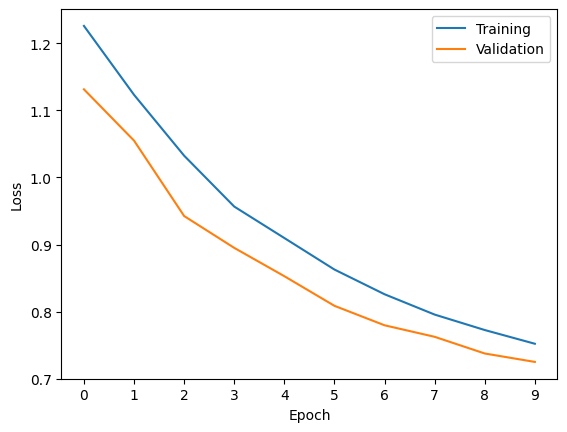


Finished Training, Testing on test set


100%|██████████| 114/114 [00:02<00:00, 45.83it/s]



 0.7579522958972997

Generating Unlabeled Result


100%|██████████| 114/114 [00:01<00:00, 73.34it/s]


AP = 0.6852546532087906
AP = 0.7601782069002136
AP = 0.1599323845037338
AP = 0.8544144327166651
AP = 0.5372514601042829
Average Precision (all classes) = 0.5994062274867372
CPU times: user 5min 52s, sys: 4.17 s, total: 5min 56s
Wall time: 6min 1s


In [ ]:
%%time
criterion = nn.CrossEntropyLoss()
##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
optimizer = torch.optim.Adam(net.parameters(), 5e-4, weight_decay=1e-5)
num_epoch = 10
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

print('\nStart training')
trn_hist = []
val_hist = []
for epoch in range(num_epoch): #TODO: Change the number of epochs
  print('-----------------Epoch = %d-----------------' % (epoch+1))
  trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
  print('Validation loss: ')
  val_loss = test(val_loader, net, criterion, device)
  trn_hist.append(trn_loss)
  val_hist.append(val_loss)

plot_hist(trn_hist, val_hist)
##########################################################################
# TODO: Submit the "Average Precision(all classes)" value in the report  #
##########################################################################
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
##############################################################################
# You can visualize your segmentation results using get_results function     #
# Your result will be dumped in the folder 'output_test'.                    #
# There will be three files for each image:                                  # 
#   (1) gt<num>.png (ground truth label)                                     #
#   (2) x<num>.png (input RGB image)                                         #
#   (3) y<num>.png (predicted output)                                        #
#                                                                            #
# TODO: Find a satisfactory result by running the next cell and report       #
#       the plot of gt<num>.png, x<num>.png and y<num>.png in the pdf        #
# Note: Your submission doesn't have to be perfect.                          #
##############################################################################
result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

cal_AP(ap_loader, net, criterion, device)

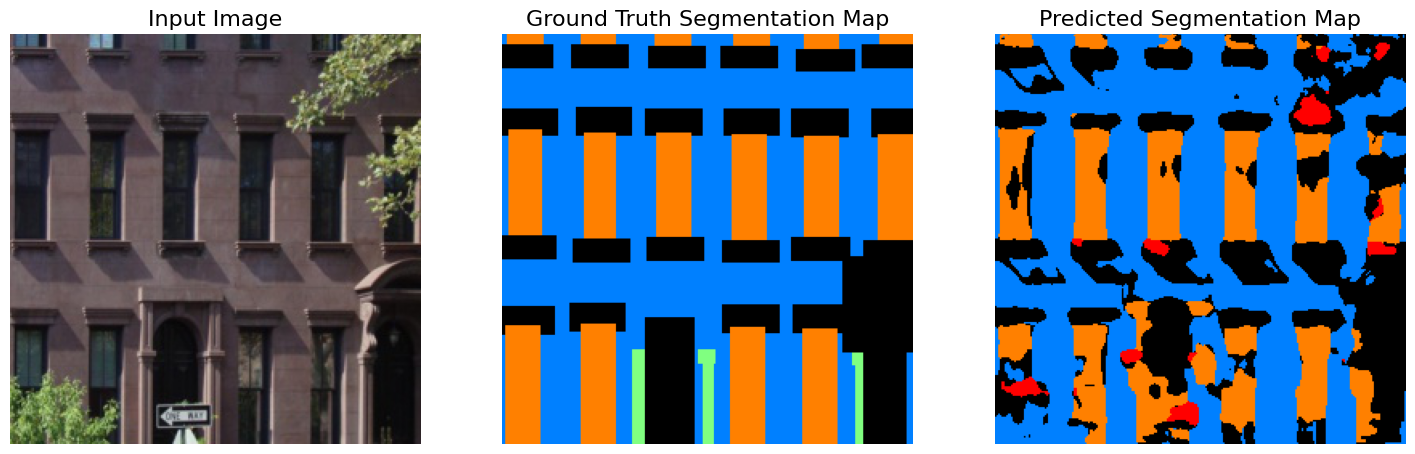

In [ ]:
########################################################################
# TODO: Find a satisfactory result from the 114 test images            #
#       Submit the result in the pdf                                   #
# Note: Your submission doesn't have to be perfect.                    #
########################################################################
img_idx = 0
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

## Acknowledgement
The Mini Facade dataset are modified from CMP Facade Database by $Radim \ Tyle \check{c}ek$ and $Radim \ \check{S}a^{'}ra$. And the starter code are modified from EECS 442 taught by Professor  David Fouhey  from University of Michigan.